---
title: Modelling Results
nav_include: 7
---

**Analysis Approach:**

Since our model runs took a very long time, we saved all of our metrics into dataframes to be loaded for later analysis. Each metric has six different values for each metric, based on the mean of that metric for the results of that batch. 

**Initial Approach** 

Initially we planned on aggregating the results of the batches and then comaring the different model results. However we found that the way we created our metrics gave us results with very high variability. If we were able to run the models again, we would change the metrics to be proportions of change, i.e. %change in followers vs the current method of absolute change in followers. This would normalize our data and allow us to directly compare results on playlists with large differences in number of songs and number of followers.

**Compromise Approach** 

In order to try and compare models with the metrics we already have, we combined the means of each batch along with the standard deviation of the means for each metric and compared those values. This led to some strange results, with the validation and test sets consistently outperforming the train set for each metric. However when you look at the $\pm 2\sigma $ bounds on the scores, you can see that there is significant overlap. 

#### Results summary

* Our model generates playlists, even matches some of the original songs in playlist from which only 1 song is taken! I.e. it addresses both goals set out for the project
* Scoring and analysis shows that clustering and song similarity is a viable approach. Visual inspection shows that playlists seem to make sense (i.e. follow the "theme" of nucleus song)
* There's still variance in results which means there's room for improvement. A lot of variance come from estimated number of followers which is a metric that is subject to Spotify promotion and "hit" phenomena

**Future work**

Extension would be to test other metaparameters listed in "Modelling". Added song tags and experimenting with words (lyrics, playlist names) would be helpful. An interesting approach would be great to try - TF/IDF and collaborative filtering which were used in https://ieatyanyans.github.io/music-recommender/

In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import string
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import gzip
import csv
import matplotlib
import matplotlib.pyplot as plt

DATA_DIR="../../../data"

In [2]:
def add(r, names, df) :
    for m in names:
        r[m].append(df[m].mean())

def tonp (r, names):
    for m in names:
        r[m] = np.array(r[m])
    
def readResults(n, shortname, name):
    m_names = ['metric', 'match', 'distance', 'numf', 'diff']
    prefix = DATA_DIR + "/results/" + shortname + str(n) + "/result_" + name
    suffix = "_" + str(n) + "_10.csv.gz"
    r = {'metric':[], 'match' : [], 'distance' : [], 'numf' : [], 'diff' : [], 'metric2' : [] }
    for i in range(1, 7) :
        fullName = prefix + str(i) + suffix
        df = pd.read_csv(fullName, compression='gzip')#.drop(['Unnamed: 0'],axis=1)
        add(r, m_names, df)
        r['metric2'].append(((1.0 / df['match']) + df['distance']).mean())
    tonp(r, m_names)
    tonp(r, ['metric2'])
    return r

def readResults2(n, shortname, name):
    m_names = ['metric', 'match', 'distance', 'numf', 'diff']
    prefix = DATA_DIR + "/results/" + shortname + str(n) + "/result_" + name
    suffix = "_" + str(n) + "_10.csv.gz"
    r = {'metric':[], 'match' : [], 'distance' : [], 'numf' : [], 'diff' : [], 'metric2' : [] }
    df_full = pd.DataFrame()
    for i in range(1, 7) :
        fullName = prefix + str(i) + suffix
        df = pd.read_csv(fullName, compression='gzip')#.drop(['Unnamed: 0'],axis=1)
        df_full = df_full.append(df)
        add(r, m_names, df)
        r['metric2'].append(((1.0 / df['match']) + df['distance']).mean())
    tonp(r, m_names)
    tonp(r, ['metric2'])
    return df_full

In [3]:
t2 = readResults(2, "t", "train")
t10 = readResults(10, "t", "train")
t50 = readResults(50, "t", "train")
t100 = readResults(100, "t", "train")

In [4]:
v2 = readResults(2, "v", "validate")
v10 = readResults(10, "v", "validate")
v50 = readResults(50, "v", "validate")
v100 = readResults(100, "v", "validate")

In [5]:
t2df = readResults2(2, "t", "train")
t10df = readResults2(10, "t", "train")
t50df = readResults2(50, "t", "train")
t100df = readResults2(100, "t", "train")

In [6]:
t2df.agg([np.mean, np.std])

,playlist_id,n_clusters,start_num,metric,match,distance,numf,diff
mean,492621.840113,2.0,10.0,41.498213,6.019840,23.742583,6.903134,17.367623
std,284337.026741,0.0,0.0,719.542719,5.571262,27.351196,1.296133,719.121609


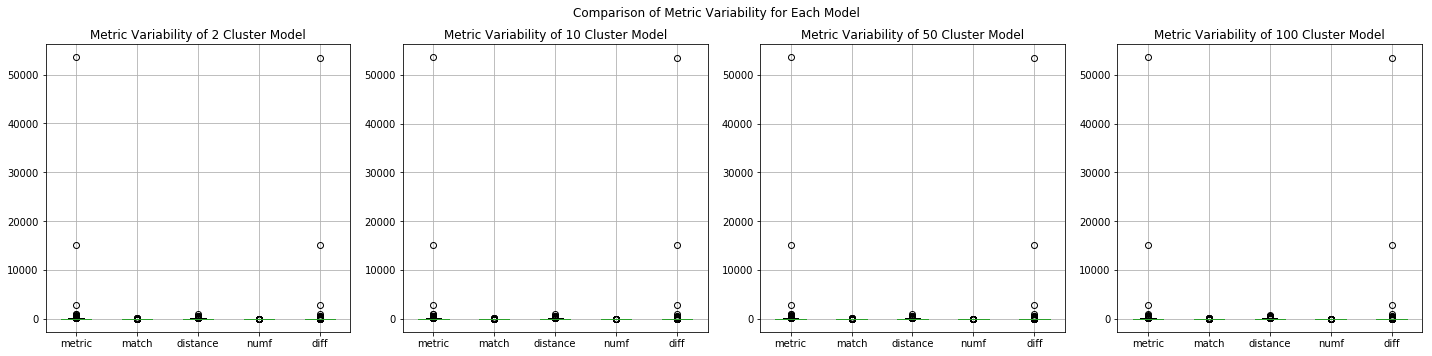

In [7]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
t2df.drop(['playlist_id', 'n_clusters', 'start_num'], axis=1).boxplot(ax=ax[0])
ax[0].set_title('Metric Variability of 2 Cluster Model')
t10df.drop(['playlist_id', 'n_clusters', 'start_num'], axis=1).boxplot(ax=ax[1])
ax[1].set_title('Metric Variability of 10 Cluster Model')
t50df.drop(['playlist_id', 'n_clusters', 'start_num'], axis=1).boxplot(ax=ax[2])
ax[2].set_title('Metric Variability of 50 Cluster Model')
t100df.drop(['playlist_id', 'n_clusters', 'start_num'], axis=1).boxplot(ax=ax[3])
ax[3].set_title('Metric Variability of 100 Cluster Model')
fig.suptitle('Comparison of Metric Variability for Each Model')
fig.tight_layout(rect=[0, 0, 1, .95])
plt.show()

The above plots show that there is significant variability in each metric, this is most pronounced in the difference in predicted followers vs actual followers metric.

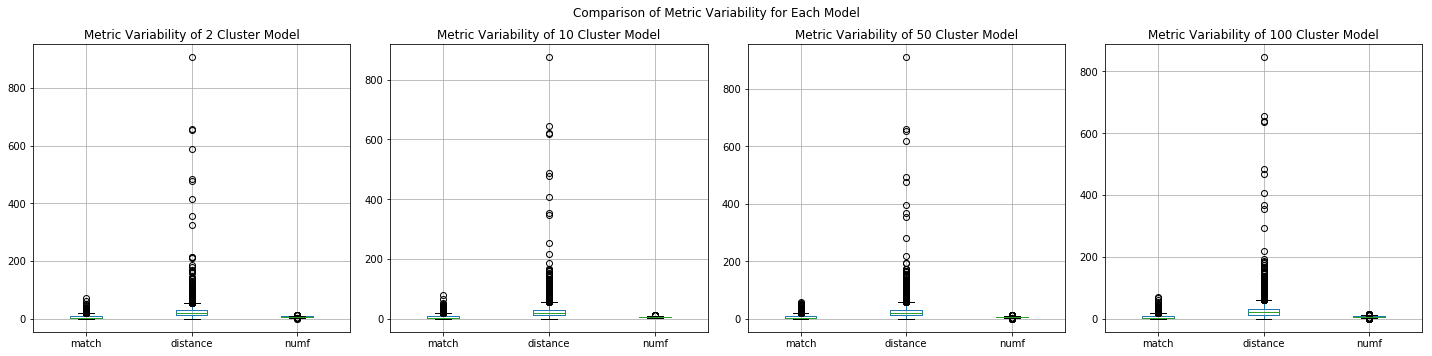

In [8]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
t2df.drop(['playlist_id', 'n_clusters', 'start_num', 'metric', 'diff'], axis=1).boxplot(ax=ax[0])
ax[0].set_title('Metric Variability of 2 Cluster Model')
t10df.drop(['playlist_id', 'n_clusters', 'start_num', 'metric', 'diff'], axis=1).boxplot(ax=ax[1])
ax[1].set_title('Metric Variability of 10 Cluster Model')
t50df.drop(['playlist_id', 'n_clusters', 'start_num', 'metric', 'diff'], axis=1).boxplot(ax=ax[2])
ax[2].set_title('Metric Variability of 50 Cluster Model')
t100df.drop(['playlist_id', 'n_clusters', 'start_num', 'metric', 'diff'], axis=1).boxplot(ax=ax[3])
ax[3].set_title('Metric Variability of 100 Cluster Model')
fig.suptitle('Comparison of Metric Variability for Each Model')
fig.tight_layout(rect=[0, 0, 1, .95])
plt.show()

The distance between playlists also has significant variability, one way we could possibly reduce this is to normalize the distance variables so that distance is a number between 0 and 1. 

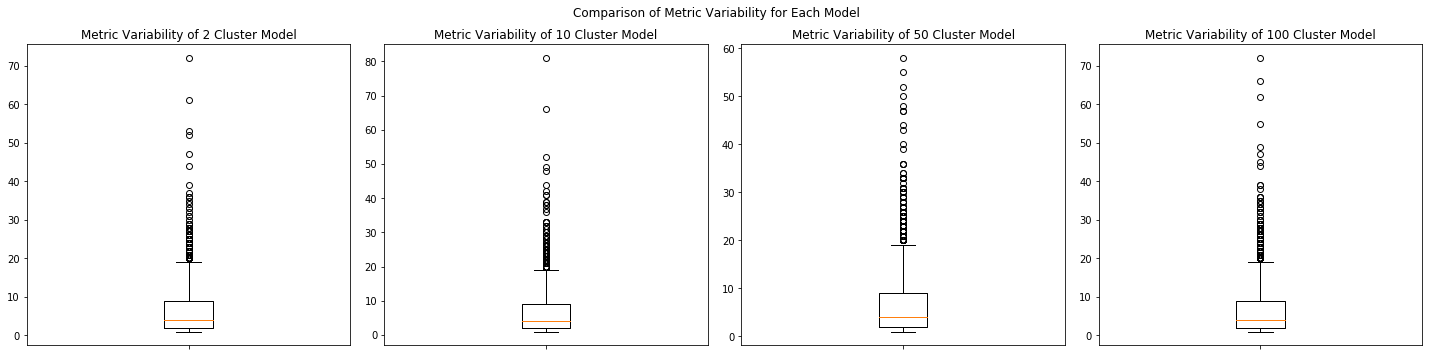

In [8]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].boxplot(t2df.match)
ax[0].set_title('Metric Variability of 2 Cluster Model')
ax[1].boxplot(t10df.match)
ax[1].set_title('Metric Variability of 10 Cluster Model')
ax[2].boxplot(t50df.match)
ax[2].set_title('Metric Variability of 50 Cluster Model')
ax[3].boxplot(t100df.match)
ax[3].set_title('Metric Variability of 100 Cluster Model')
for axis in ax:
    axis.set_xticklabels('')
fig.suptitle('Comparison of Metric Variability for Each Model')
fig.tight_layout(rect=[0, 0, 1, .95])
plt.show()

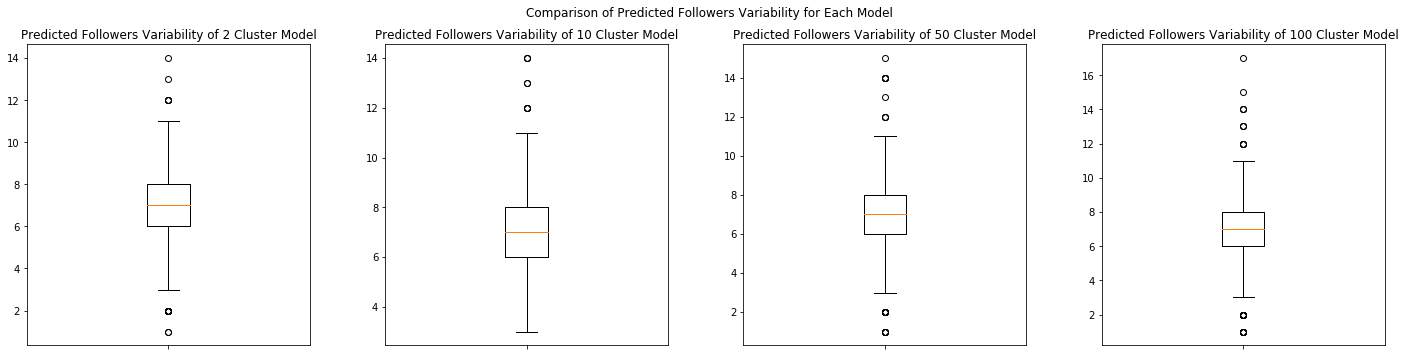

In [9]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].boxplot(t2df.numf)
ax[0].set_title('Predicted Followers Variability of 2 Cluster Model')
ax[1].boxplot(t10df.numf)
ax[1].set_title('Predicted Followers Variability of 10 Cluster Model')
ax[2].boxplot(t50df.numf)
ax[2].set_title('Predicted Followers Variability of 50 Cluster Model')
ax[3].boxplot(t100df.numf)
ax[3].set_title('Predicted Followers Variability of 100 Cluster Model')
for axis in ax:
    axis.set_xticklabels('')
fig.suptitle('Comparison of Predicted Followers Variability for Each Model')
fig.tight_layout(rect=[0, 0, 1, .95])
plt.show()

In [10]:
test2 = readResults(2, 'test', 'test')
test10 = readResults(10, 'test', 'test')

In [11]:
def make_mean_metrics(models, sn):
    results_dict = {}
    #models = [t2, t10, t50, t100]
    names = [2, 10, 50, 100]
    for model, name in zip(models, names):
        model_params = {}
        for key in model:
            model_params[key] = np.mean(model[key])
            model_params[key+'std'] = np.std(model[key])
        results_dict[sn+str(name)] = model_params
    return results_dict

In [12]:
models_train = [t2, t10, t50, t100]
train_dict = make_mean_metrics(models_train, 't')
results_train = pd.DataFrame.from_dict(train_dict).T
results_train

,diff,diffstd,distance,distancestd,match,matchstd,metric,metric2,metric2std,metricstd,numf,numfstd
t2,17.366214,19.586043,23.742464,1.204582,6.019813,0.117456,41.496689,24.130509,1.202147,18.936747,6.903080,0.654374
t10,17.447881,19.232502,24.761268,0.929312,6.129652,0.176668,42.599327,25.151356,0.934653,18.970186,7.006165,0.197402
t50,17.313173,19.268623,25.829698,0.902331,6.151795,0.124508,43.530253,26.217108,0.903429,19.148228,6.777501,0.138788
t100,17.419482,19.445556,25.663053,0.693858,6.215457,0.099706,43.468382,26.048898,0.689577,19.784372,6.772136,0.073181


In [13]:
models_validate = [v2, v10, v50, v100]
validate_dict = make_mean_metrics(models_validate, 'v')
results_validate = pd.DataFrame.from_dict(validate_dict).T
results_validate

,diff,diffstd,distance,distancestd,match,matchstd,metric,metric2,metric2std,metricstd,numf,numfstd
v2,8.383877,3.004734,23.266120,0.923800,6.221482,0.087430,32.019275,23.635325,0.926099,3.192091,6.924442,0.808971
v10,7.866056,2.634214,24.467220,0.964562,6.322889,0.081322,32.699332,24.833359,0.962880,3.407503,6.181138,0.223869
v50,7.961983,2.822155,24.610007,0.909844,6.493108,0.070977,32.932138,24.970164,0.908917,3.431358,6.253282,0.109693
v100,7.884393,2.696971,24.743925,0.742098,6.541668,0.095974,32.985807,25.101392,0.744146,3.234505,6.126036,0.171505


In [14]:
models_test = [test2, test10]
test_dict = make_mean_metrics(models_test, 'test')
results_test = pd.DataFrame.from_dict(test_dict).T
results_test

,diff,diffstd,distance,distancestd,match,matchstd,metric,metric2,metric2std,metricstd,numf,numfstd
test2,13.347084,7.996984,25.105574,1.956354,6.189874,0.139431,38.832057,25.48498,1.956773,8.834247,7.429872,0.323859
test10,12.797532,8.089814,24.755806,0.846285,6.294219,0.155728,37.930501,25.13291,0.847011,8.529533,6.795775,0.237814


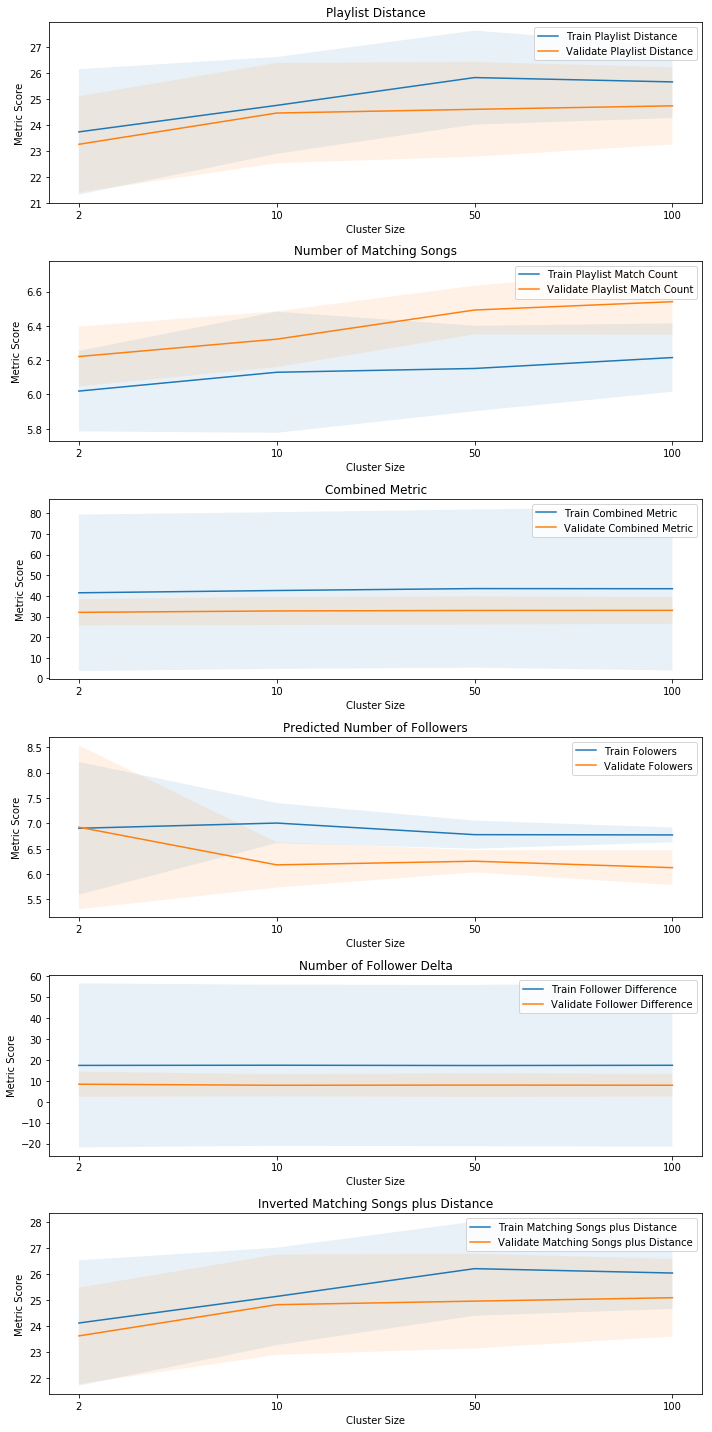

In [15]:
plot_alpha = .1
fig, ax = plt.subplots(6,1, figsize=(10,20))
labels_train = ['Train Playlist Distance', 'Train Playlist Match Count', 'Train Combined Metric', 'Train Folowers', 
                'Train Follower Difference', 'Train Matching Songs plus Distance']
labels_validate = ['Validate Playlist Distance', 'Validate Playlist Match Count', 'Validate Combined Metric', 
                   'Validate Folowers', 'Validate Follower Difference', 'Validate Matching Songs plus Distance']
plot_order = ['distance', 'match', 'metric', 'numf', 'diff', 'metric2']
titles = ['Playlist Distance', 'Number of Matching Songs', 'Combined Metric', 'Predicted Number of Followers', 
          'Number of Follower Delta', 'Inverted Matching Songs plus Distance']
names = [2, 10, 50, 100]
# results_train.plot(y='diff', ax=ax[0])
# results_train.plot(y='distance', ax=ax[1])
# results_train.plot(y='match', ax=ax[2])
# results_train.plot(y='metric', ax=ax[3])
for axis, po, labelt, labelv, title in \
zip(ax, plot_order, labels_train, labels_validate, titles):
    results_train.plot(y=po, ax=axis, label=labelt)
    axis.fill_between(np.arange(4), results_train[po] + 2*results_train[po+'std'],
                      results_train[po] - 2*results_train[po+'std'], alpha=plot_alpha)
    results_validate.plot(y=po, ax=axis, label=labelv)
    axis.fill_between(np.arange(4), results_validate[po] + 2*results_validate[po+'std'],
                      results_validate[po] - 2*results_validate[po+'std'], alpha=plot_alpha)
    axis.set_xlabel('Cluster Size')
    axis.set_ylabel('Metric Score')
    axis.set_xticks(np.arange(4))
    axis.set_xticklabels(names)
    axis.set_title(title)
fig.tight_layout()
plt.show()

In [16]:
results_validate_test = results_validate.loc[['v2', 'v10'], :]
results_train_test = results_train.loc[['t2', 't10'], :]

In [17]:
po, results_train[po+'std']

('metric2', t2      1.202147
 t10     0.934653
 t50     0.903429
 t100    0.689577
 Name: metric2std, dtype: float64)

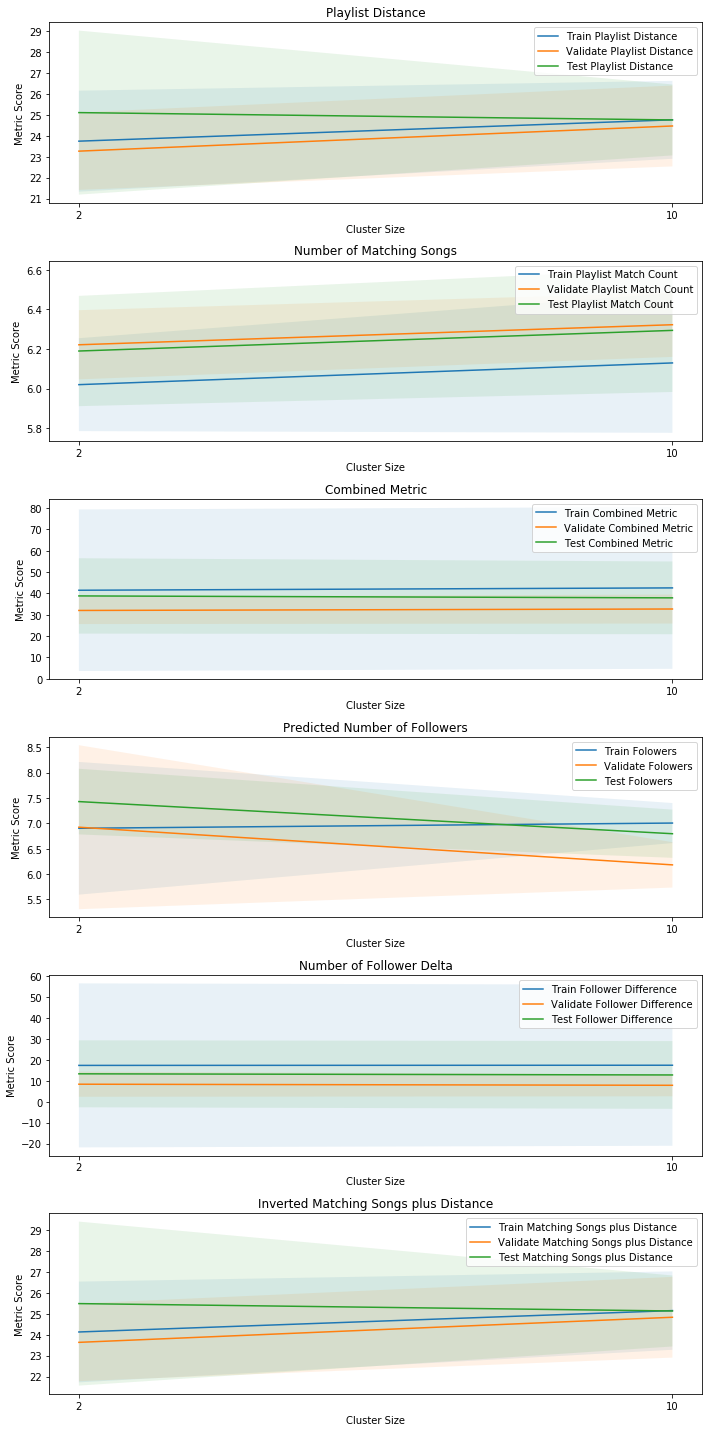

In [18]:
fig, ax = plt.subplots(6,1, figsize=(10,20))
labels_train = ['Train Playlist Distance', 'Train Playlist Match Count', 'Train Combined Metric', 'Train Folowers', 
                'Train Follower Difference', 'Train Matching Songs plus Distance']
labels_validate = ['Validate Playlist Distance', 'Validate Playlist Match Count', 'Validate Combined Metric', 
                   'Validate Folowers', 'Validate Follower Difference', 'Validate Matching Songs plus Distance']
labels_test = ['Test Playlist Distance', 'Test Playlist Match Count', 'Test Combined Metric', 'Test Folowers', 
               'Test Follower Difference', 'Test Matching Songs plus Distance']
plot_order = ['distance', 'match', 'metric', 'numf', 'diff', 'metric2']
titles = ['Playlist Distance', 'Number of Matching Songs', 'Combined Metric', 'Predicted Number of Followers', 
          'Number of Follower Delta', 'Inverted Matching Songs plus Distance']
names = [2, 10]
# results_train.plot(y='diff', ax=ax[0])
# results_train.plot(y='distance', ax=ax[1])
# results_train.plot(y='match', ax=ax[2])
# results_train.plot(y='metric', ax=ax[3])
for axis, po, labelt, labelv, title, labeltest in \
zip(ax, plot_order, labels_train, labels_validate, titles, labels_test):
    results_train_test.plot(y=po, ax=axis, label=labelt)
    axis.fill_between(np.arange(2), results_train_test[po] + 2*results_train_test[po+'std'],
                      results_train_test[po] - 2*results_train_test[po+'std'], alpha=plot_alpha)
    results_validate_test.plot(y=po, ax=axis, label=labelv)
    axis.fill_between(np.arange(2), results_validate_test[po] + 2*results_validate_test[po+'std'],
                      results_validate_test[po] - 2*results_validate_test[po+'std'], alpha=plot_alpha)
    results_test.plot(y=po, ax=axis, label=labeltest)
    axis.fill_between(np.arange(2), results_test[po] + 2*results_test[po+'std'],
                      results_test[po] - 2*results_test[po+'std'], alpha=plot_alpha)
    axis.set_xlabel('Cluster Size')
    axis.set_ylabel('Metric Score')
    axis.set_xticks(np.arange(2))
    axis.set_xticklabels(names)
    axis.set_title(title)
fig.tight_layout()
plt.show()

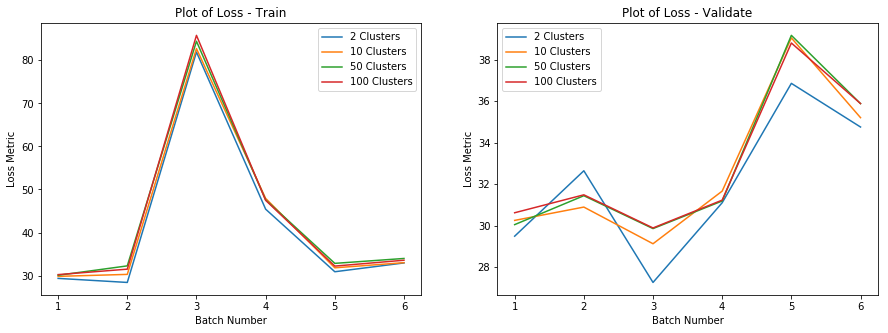

In [19]:
x = range(1, 7)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Loss - Train')
axes[0].plot(x, t2['metric'], label='2 Clusters')
axes[0].plot(x, t10['metric'], label='10 Clusters')
axes[0].plot(x, t50['metric'], label='50 Clusters')
axes[0].plot(x, t100['metric'], label='100 Clusters')
axes[0].set_xlabel('Batch Number')
axes[0].set_ylabel('Loss Metric')
axes[0].legend()
axes[1].set_title('Plot of Loss - Validate')
axes[1].plot(x, v2['metric'], label='2 Clusters')
axes[1].plot(x, v10['metric'], label='10 Clusters')
axes[1].plot(x, v50['metric'], label='50 Clusters')
axes[1].plot(x, v100['metric'], label='100 Clusters')
axes[1].set_xlabel('Batch Number')
axes[1].set_ylabel('Loss Metric')
axes[1].legend()
plt.show()

Looking at the combined metric by batch shows that each model reacted to the individual batches in a fairly consistent manner. This is slightly less true for the validation set, but the relationship is still there for at least the 10, 50 and 100 cluster models.

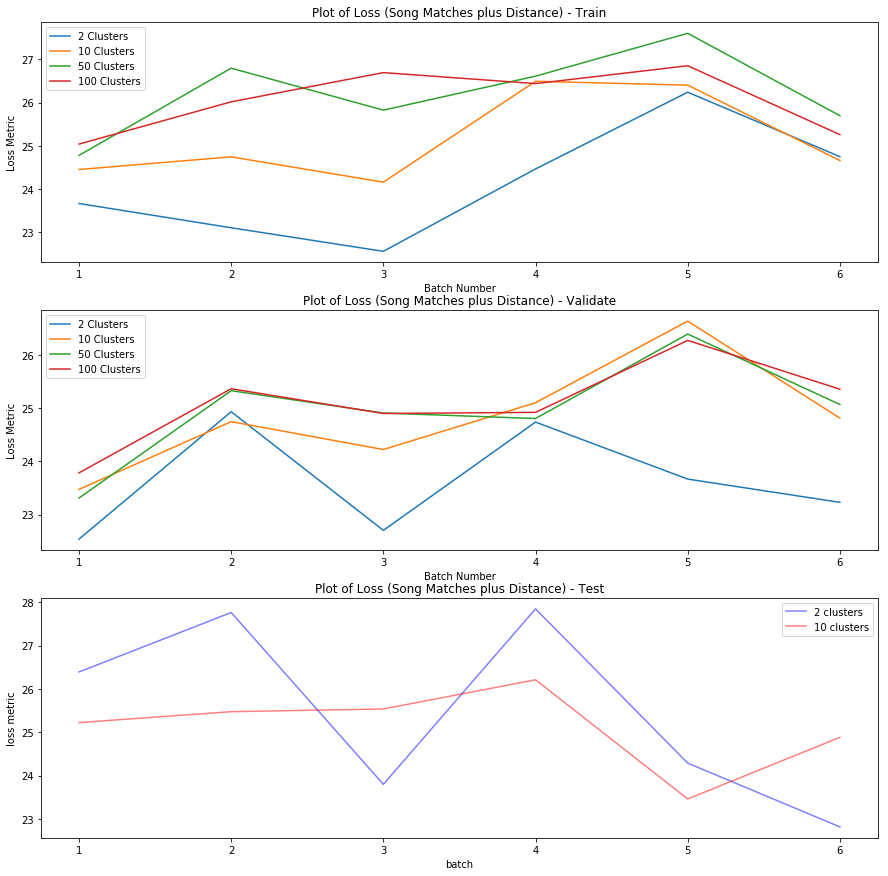

In [20]:
x = range(1, 7)
fig, axes = plt.subplots(3,1,figsize=(15,15))
axes = axes.ravel()
axes[0].set_title('Plot of Loss (Song Matches plus Distance) - Train')
axes[0].plot(x, t2['metric2'], label='2 Clusters')
axes[0].plot(x, t10['metric2'], label='10 Clusters')
axes[0].plot(x, t50['metric2'], label='50 Clusters')
axes[0].plot(x, t100['metric2'], label='100 Clusters')
axes[0].set_xlabel('Batch Number')
axes[0].set_ylabel('Loss Metric')
axes[0].legend()
axes[1].set_title('Plot of Loss (Song Matches plus Distance) - Validate')
axes[1].plot(x, v2['metric2'], label='2 Clusters')
axes[1].plot(x, v10['metric2'], label='10 Clusters')
axes[1].plot(x, v50['metric2'], label='50 Clusters')
axes[1].plot(x, v100['metric2'], label='100 Clusters')
axes[1].set_xlabel('Batch Number')
axes[1].set_ylabel('Loss Metric')
axes[1].legend()
axes[2].set_title('Plot of Loss (Song Matches plus Distance) - Test')
axes[2].plot(x, test2['metric2'], alpha=0.5, color='b', label='2 clusters')
axes[2].plot(x, test10['metric2'], alpha=0.5, color='r', label='10 clusters')
axes[2].set_xlabel('batch')
axes[2].set_ylabel('loss metric')
axes[2].legend()
plt.show()

We created a second combined metric aimed at reducing the variability, this metric has results that are more in line with expectations with the model performing slightly better on the train set than the other sets. 